In [5]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

import pymc3 as pm
import GPy
import arch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
import pickle

import warnings
warnings.filterwarnings('ignore')

In [298]:
with open('data0904.pickle', 'rb') as pp:
    data = pickle.load(pp)

In [299]:
mapping = {'alum':'Алюминий (тонна/доллар США)',
            'bovespa':'Индекс Bovespa',
          'brent': 'Нефть марки Brent (баррель/доллар США)',
           'bse_sensex': 'Индекс BSE SENSEX',
           'btc_usd': 'Bitcoin/Доллар США',
           'eth_usd': 'Ethereum/Доллар США',
           'eurgbr':'Евро/Британский фунт стерлинга',
           'eurrub': 'Евро/Российский рубль',
           'eurusd': 'Евро/Доллар США',
           'gold': 'Золото (унция/доллар США)',
           'imoex':'Индекс Московской Биржи',
           'lukoil':'Акции Лукойл',
           'megafon':'Акции Мегафон',
           'mts':'Акции МТС',
           'n225': 'Индекс Nikkei 225',
           'nasdaq': 'Индекс NASDAQ Composite',
           'nickel': 'Никель (тонна/доллар США)',
           'nlmk': 'Акции НЛМК',
           'nornikel': 'Акции Норильский Никель',
           'sevstal':'Акции Северсталь',
#            'plat': 'Платина',
           'rtsi':'Индекс PTC',
           'shanghai': 'Индекс Shanghai Composite',
           'silver': 'Серебро (унция/доллар США)',
           'usdrub': 'Доллар США/Российский рубль',
           'wheat': 'Пшеница (5000 бушелей/доллар США)',
#            'yandex': 'Акции Yandex'
          }

currencies = ['btc_usd', 'eth_usd', 'eurgbr', 'eurrub', 'eurusd','usdrub']
indicies = ['bovespa', 'bse_sensex', 'imoex', 'n225', 'nasdaq', 'rtsi']
stocks = ['lukoil','megafon','mts', 'nlmk','nornikel','sevstal']
commodities = ['alum', 'brent','gold','nickel', 'silver', 'wheat']

In [85]:
ts = data['btc_usd']['return']
ts = ts.reset_index(drop=True)
first = 0
last = 251

In [173]:
ts_eval = data['btc_usd']['return_abs']
ts_eval = ts_eval.reset_index(drop=True)

In [335]:
def MSE2(y_true, y_eval):
    y_true = y_true.values
    y_eval = y_eval.values
    if y_true.shape !=  y_eval.shape:
        y_eval = y_eval.reshape(y_true.shape)
    n = y_true.shape[0]
    return sum(((y_true**2) - (y_eval**2))**2) / n

def MAE2(y_true, y_eval):
    y_true = y_true.values
    y_eval = y_eval.values
    if y_true.shape !=  y_eval.shape:
        y_eval = y_eval.reshape(y_true.shape)
    n = y_true.shape[0]
    return np.sum(np.abs((y_true**2) - (y_eval**2))) / n

def MdRAE(y_true, y_eval):
    y_true = y_true.values
    y_eval = y_eval.values
    if y_true.shape !=  y_eval.shape:
        y_eval = y_eval.reshape(y_true.shape)
    y_true = pd.Series(y_true)
    y_eval = pd.Series(y_eval)
    temp =  ((y_true - y_eval)/ (y_true - y_true.shift()))
    temp = temp.dropna()
    return np.median(np.abs(temp))

def sMAPE(y_true, y_eval):
    y_true = y_true.values
    y_eval = y_eval.values
    if y_true.shape !=  y_eval.shape:
        y_eval = y_eval.reshape(y_true.shape)
    n = y_true.shape[0]
    return np.sum((np.abs(y_true - y_eval)/ (y_true + y_eval))*200) / n
    
    

In [184]:
def fixed_window_garch(ts, window_size=252, model_params=('Garch',1,0,1, 2.0, 'Normal')):
    from datetime import datetime
    dt1 = datetime.now()

    ts_forecasts = {}
    
    first = 0
    last = window_size - 1
    
    model_to_fit = arch.arch_model(ts, 
                              vol=model_params[0],
                              p=model_params[1], 
                              o=model_params[2], 
                              q=model_params[3],
                              power=model_params[4],
                            dist=model_params[5])
    for t in range(ts.shape[0] - window_size):
        garch_results = model_to_fit.fit(first_obs=first+t, last_obs=last+t, update_freq=0, disp='off')
        temp_res = garch_results.forecast(horizon=1).variance
        temp_forecast = temp_res.iloc[last+t]
        ts_forecasts[temp_forecast.name] = temp_forecast
        if t%500 == 0:
            print('Модель {}: посчитана {} точка'.format(model_to_fit.volatility.name, t + 1))
    fcst_var = pd.DataFrame(ts_forecasts).T
    dt2 = datetime.now() - dt1
    print('Выполнено за {}'.format(dt2))
    return fcst_var

In [322]:
garch_param_dict = {
                    'GARCH': ('Garch',1,0,1, 2.0, 'Normal'),
                    'GJR-GARCH':('Garch',1,1,1, 2.0, 'Normal'),
                    'TGARCH':('Garch',1,1,1, 1.0, 'Normal')
                    
                   }

In [331]:
results_stocks={}
for stock_name in stocks:
    results_stocks[stock_name] = {}
    ts = data[stock_name]['return']
    
    ts = ts.reset_index(drop=True)

    print('Работа с активом {}'.format(mapping[stock_name]))
    print('-----------------------------------')
    for garch_param in garch_param_dict:
        results_stocks[stock_name][garch_param] = fixed_window_garch(ts, model_params=garch_param_dict[garch_param])
        
        

Работа с активом Акции Лукойл
-----------------------------------
Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501 точка
Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Модель GARCH: посчитана 3501 точка
Модель GARCH: посчитана 4001 точка
Модель GARCH: посчитана 4501 точка
Выполнено за 0:02:36.555295
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Модель GJR-GARCH: посчитана 3501 точка
Модель GJR-GARCH: посчитана 4001 точка
Модель GJR-GARCH: посчитана 4501 точка
Выполнено за 0:03:03.987917
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчита

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 4501 точка
Выполнено за 0:03:20.157180
Работа с активом Акции Мегафон
-----------------------------------
Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Выполнено за 0:00:44.608798
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Выполнено за 0:00:52.322072
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Выполнено за 0:01:01.344961
Работа с активом Акции МТС
-----------------------------------
Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univar

Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Модель GARCH: посчитана 3501 точка
Выполнено за 0:02:12.299157
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 3501 точка
Выполнено за 0:02:33.709854
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 1501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Выполнено за 0:02:47.561846
Работа с активом Акции НЛМК
-----------------------------------
Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501 точка
Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Выполнено за 0:01:45.248895
Модель GJR-GARCH: посчитана 1 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Выполнено за 0:02:01.092134
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Выполнено за 0:02:10.928864
Работа с активом Акции Норильский Никель
-----------------------------------
Модель GARCH: посчитана 1 точка
Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501 точка
Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Модель GARCH: посчитана 3501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GARCH: посчитана 4001 точка
Выполнено за 0:02:13.605220
Модель GJR-GARCH: посчитана 1 точка
Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Модель GJR-GARCH: посчитана 3501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 4001 точка
Выполнено за 0:02:44.890028
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Модель TARCH/ZARCH: посчитана 3501 точка
Модель TARCH/ZARCH: посчитана 4001 точка
Выполнено за 0:02:55.461298
Работа с активом Акции Северсталь
-----------------------------------
Модель GARCH: посчитана 1 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GARCH: посчитана 501 точка
Модель GARCH: посчитана 1001 точка
Модель GARCH: посчитана 1501 точка
Модель GARCH: посчитана 2001 точка
Модель GARCH: посчитана 2501 точка
Модель GARCH: посчитана 3001 точка
Выполнено за 0:01:48.680364
Модель GJR-GARCH: посчитана 1 точка


 C:\Users\Georgy\Anaconda3\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning:The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.



Модель GJR-GARCH: посчитана 501 точка
Модель GJR-GARCH: посчитана 1001 точка
Модель GJR-GARCH: посчитана 1501 точка
Модель GJR-GARCH: посчитана 2001 точка
Модель GJR-GARCH: посчитана 2501 точка
Модель GJR-GARCH: посчитана 3001 точка
Выполнено за 0:02:08.047611
Модель TARCH/ZARCH: посчитана 1 точка
Модель TARCH/ZARCH: посчитана 501 точка
Модель TARCH/ZARCH: посчитана 1001 точка
Модель TARCH/ZARCH: посчитана 1501 точка
Модель TARCH/ZARCH: посчитана 2001 точка
Модель TARCH/ZARCH: посчитана 2501 точка
Модель TARCH/ZARCH: посчитана 3001 точка
Выполнено за 0:02:15.789861


In [334]:
# with open('results_stocks1104.pickle', 'wb') as rs:
#     pickle.dump(results_stocks, rs)

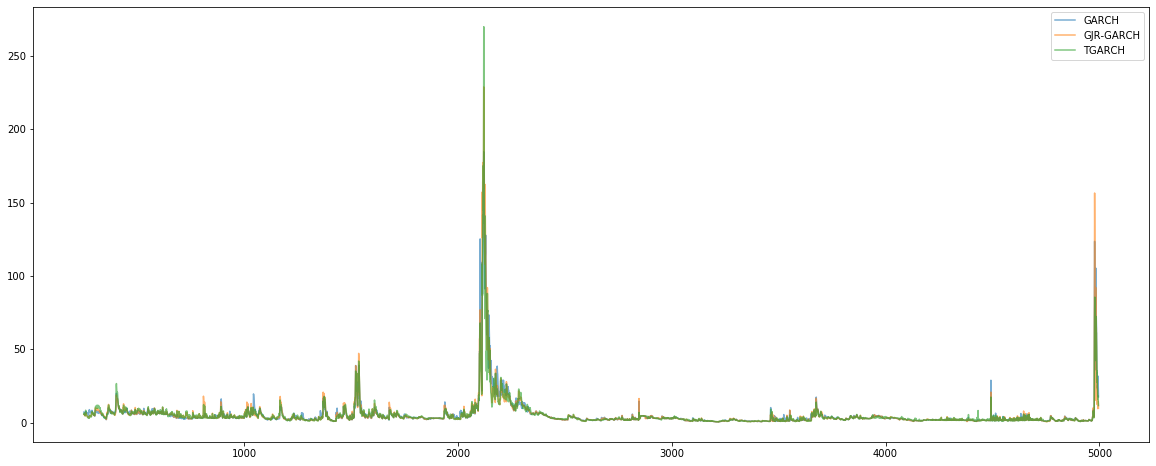

In [343]:
plt.figure(figsize=(20,8))
for i in results_stocks['lukoil']:
    plt.plot(results_stocks['lukoil'][i], alpha=0.6, label=i)
plt.legend()

In [354]:
data['nornikel']['return_abs'][252:], results_stocks['nornikel']['GARCH']

(date
 2002-11-05    4.163695
 2002-11-06    0.318980
 2002-11-10    0.007987
 2002-11-11    0.971076
 2002-11-12    2.860313
                 ...   
 2020-04-01    2.942765
 2020-04-02    0.242424
 2020-04-03    0.178806
 2020-04-06    2.889746
 2020-04-07    0.722245
 Name: return_abs, Length: 4353, dtype: float64,             h.1
 251    5.341098
 252    5.349542
 253    5.440676
 254    5.428893
 255    5.417211
 ...         ...
 4599  27.864766
 4600  26.151302
 4601  23.718340
 4602  21.504004
 4603  20.226153
 
 [4353 rows x 1 columns])

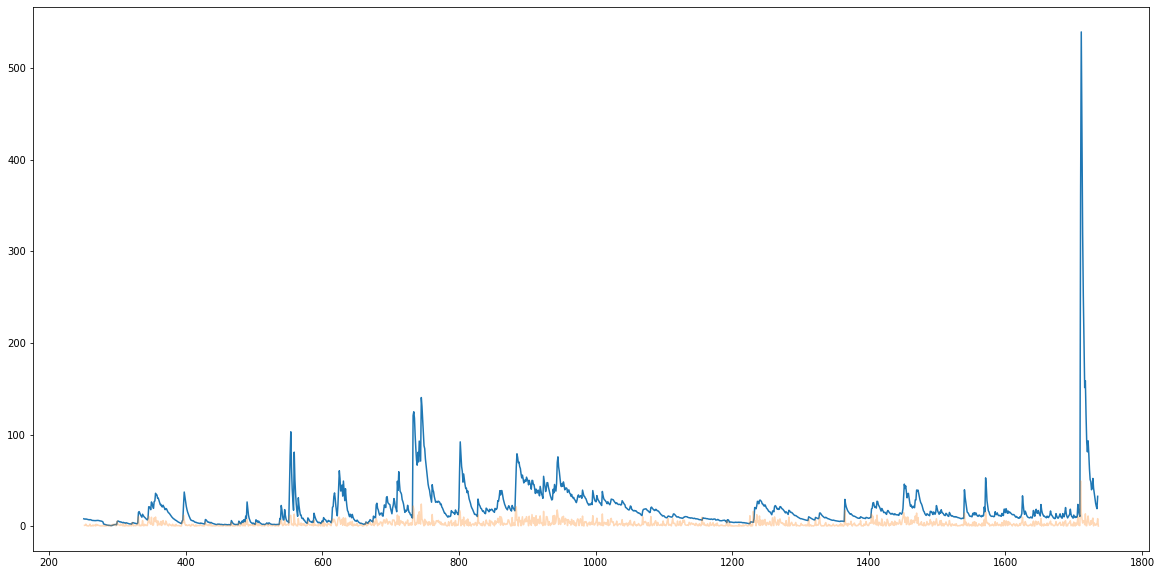

In [329]:
plt.figure(figsize=(20,10))
plt.plot(ff)
plt.plot(ts_eval[252:], alpha=0.3)

In [400]:
def model_quality(data_true, data_eval, asset_group=stocks, window_size=252):

    ql=[]
    ql_dict = {}
    for asset_name in data_eval:
        ql_dict[asset_name] = {}
        for model_name in data_eval[asset_name]:
            
            y_true = data_true[asset_name]['return_abs'][window_size:]
            y_eval = data_eval[asset_name][model_name]

            mse1 = mean_squared_error(y_true, y_eval)
            mae1 = mean_absolute_error(y_true, y_eval)
            mdrae = MdRAE(y_true, y_eval)
            smape =sMAPE(y_true, y_eval)
            
            ql_dict[asset_name][model_name] = [mse1,
                       mae1,
                       mdrae,smape]
            ql.append([mse1,
                       mae1,
                       mdrae,smape])
            
    ql = np.array(ql).reshape(6,-1)
            
    multi_index = pd.MultiIndex.from_product([['GARCH','GJR-GARCH','TGARCH'],['MSE1','MAE1', 'MdRAE', 'sMAPE']], 
                                              names=['Модель','Метрика качества']) 
    
    return pd.DataFrame(ql, index=asset_group, columns=multi_index)
    
    
    

In [404]:
df = model_quality(data,results_stocks)
# df.to_excel('stocks_df1104.xls')

In [394]:
ql_dict

{'lukoil': {'GARCH': [121.84617999896686,
   3.8758678798425845,
   2.2295733934586695,
   99.44771234817792],
  'GJR-GARCH': [137.77037808187495,
   3.8283702796249286,
   2.263681272406547,
   98.90113873684662],
  'TGARCH': [112.18509811386745,
   3.7169498417181837,
   2.3827301575620448,
   100.03432733989129]},
 'megafon': {'GARCH': [91.22092103685401,
   2.9692829537004997,
   2.9565994846363024,
   110.98004281370913],
  'GJR-GARCH': [259.06993581919653,
   3.230528846443815,
   2.881327624087594,
   109.41795309915999],
  'TGARCH': [126.54482033473536,
   2.920265309038149,
   2.9404931492890953,
   109.74917125584163]},
 'mts': {'GARCH': [121.67549812487377,
   3.7979827443932037,
   2.4475751647548503,
   105.34399217987725],
  'GJR-GARCH': [204.55483038046376,
   4.096172101475928,
   2.4089952352695914,
   104.92721160429817],
  'TGARCH': [129.56590892825008,
   3.7063852669022843,
   2.495397582667289,
   105.91199878669327]},
 'nlmk': {'GARCH': [493.22491884403513,
   7.

In [243]:
mean_squared_error(np.sqrt(ts_eval[252:]), np.sqrt(ff)), mean_squared_error(ts_eval[252:], ff)

(9.597782500073041, 1039.0429648643708)

In [242]:
sMAPE(ts_eval[252:], ff)

142.9732140065596

In [134]:
gjr = arch.arch_model(ts, vol='Garch', p=1, o=0, q=1, power=2.0)
# garch = arch.arch_model(ts['return'], vol='Garch', p=1, o=0, q=1, power=1.0)

In [124]:
# gjr_result = gjr.fit()
garch_result = garch.fit(update_freq=0, disp='off', show_warning=False)

In [143]:
gjr.volatility.name

'GARCH'

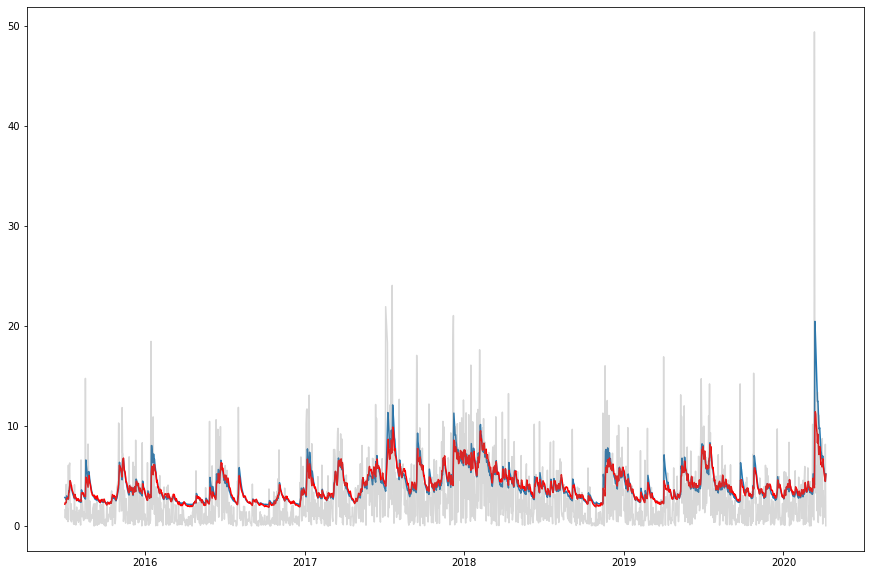

In [45]:
plt.figure(figsize=(15,10))
plt.plot(gjr_result.conditional_volatility)
plt.plot(garch_result.conditional_volatility, c='red')
plt.plot(ts['return_abs'], color='grey', alpha=0.3)